In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=3 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.000e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 28533 
    Total predicted counts          : 28275.76
    Total off counts                : 101661.00

    Total background counts         : 20332.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 2000
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 12.9 s, sys: 64.6 ms, total: 13 s
Wall time: 13.1 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 28089 
    Total predicted counts          : 28333.76
    Total off counts                : 101951.00

    Total background counts         : 20390.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 27989 
    Total predicted counts          : 28399.36
    Total off counts                : 102279.00

    Total background counts         : 20

SpectrumDatasetOnOff

    Name                            : obs_17 

    Total counts                    : 28186 
    Total predicted counts          : 28221.16
    Total off counts                : 101388.00

    Total background counts         : 20277.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_18 

    Total counts                    : 28341 
    Total predicted counts          : 28276.16
    Total off counts                : 101663.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_39 

    Total counts                    : 28418 
    Total predicted counts          : 28262.36
    Total off counts                : 101594.00

    Total background counts         : 20318.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_40 

    Total counts                    : 28335 
    Total predicted counts          : 28200.36
    Total off counts                : 101284.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_58 

    Total counts                    : 28175 
    Total predicted counts          : 28246.56
    Total off counts                : 101515.00

    Total background counts         : 20303.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_59 

    Total counts                    : 28169 
    Total predicted counts          : 28338.16
    Total off counts                : 101973.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_78 

    Total counts                    : 28261 
    Total predicted counts          : 28114.36
    Total off counts                : 100854.00

    Total background counts         : 20170.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_79 

    Total counts                    : 28201 
    Total predicted counts          : 28329.76
    Total off counts                : 101931.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_97 

    Total counts                    : 28130 
    Total predicted counts          : 28376.56
    Total off counts                : 102165.00

    Total background counts         : 20433.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_98 

    Total counts                    : 28378 
    Total predicted counts          : 28208.76
    Total off counts                : 101326.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_116 

    Total counts                    : 28364 
    Total predicted counts          : 28176.16
    Total off counts                : 101163.00

    Total background counts         : 20232.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_117 

    Total counts                    : 28060 
    Total predicted counts          : 28247.56
    Total off counts                : 101520.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_136 

    Total counts                    : 28156 
    Total predicted counts          : 28330.36
    Total off counts                : 101934.00

    Total background counts         : 20386.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_137 

    Total counts                    : 28523 
    Total predicted counts          : 28305.36
    Total off counts                : 101809.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_152 

    Total counts                    : 28160 
    Total predicted counts          : 28137.96
    Total off counts                : 100972.00

    Total background counts         : 20194.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_153 

    Total counts                    : 28196 
    Total predicted counts          : 28207.96
    Total off counts                : 101322.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_168 

    Total counts                    : 28372 
    Total predicted counts          : 28165.16
    Total off counts                : 101108.00

    Total background counts         : 20221.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_169 

    Total counts                    : 28140 
    Total predicted counts          : 28331.76
    Total off counts                : 101941.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_187 

    Total counts                    : 28226 
    Total predicted counts          : 28090.76
    Total off counts                : 100736.00

    Total background counts         : 20147.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_188 

    Total counts                    : 28137 
    Total predicted counts          : 28253.56
    Total off counts                : 101550.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_205 

    Total counts                    : 28564 
    Total predicted counts          : 28211.96
    Total off counts                : 101342.00

    Total background counts         : 20268.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_206 

    Total counts                    : 27988 
    Total predicted counts          : 28201.56
    Total off counts                : 101290.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_221 

    Total counts                    : 28207 
    Total predicted counts          : 28305.16
    Total off counts                : 101808.00

    Total background counts         : 20361.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.93

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_222 

    Total counts                    : 28276 
    Total predicted counts          : 28359.36
    Total off counts                : 102079.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_242 

    Total counts                    : 28319 
    Total predicted counts          : 28215.56
    Total off counts                : 101360.00

    Total background counts         : 20272.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_243 

    Total counts                    : 28458 
    Total predicted counts          : 28273.36
    Total off counts                : 101649.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_262 

    Total counts                    : 28661 
    Total predicted counts          : 28263.16
    Total off counts                : 101598.00

    Total background counts         : 20319.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 24.11

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_263 

    Total counts                    : 28470 
    Total predicted counts          : 28332.56
    Total off counts                : 101945.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_283 

    Total counts                    : 28317 
    Total predicted counts          : 28172.56
    Total off counts                : 101145.00

    Total background counts         : 20229.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_284 

    Total counts                    : 28069 
    Total predicted counts          : 28225.96
    Total off counts                : 101412.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_304 

    Total counts                    : 28372 
    Total predicted counts          : 28166.96
    Total off counts                : 101117.00

    Total background counts         : 20223.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_305 

    Total counts                    : 28369 
    Total predicted counts          : 28227.16
    Total off counts                : 101418.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_326 

    Total counts                    : 28182 
    Total predicted counts          : 28284.76
    Total off counts                : 101706.00

    Total background counts         : 20341.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_327 

    Total counts                    : 28171 
    Total predicted counts          : 28165.16
    Total off counts                : 101108.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_343 

    Total counts                    : 28169 
    Total predicted counts          : 28254.76
    Total off counts                : 101556.00

    Total background counts         : 20311.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_344 

    Total counts                    : 28168 
    Total predicted counts          : 28153.16
    Total off counts                : 101048.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_358 

    Total counts                    : 28213 
    Total predicted counts          : 28244.96
    Total off counts                : 101507.00

    Total background counts         : 20301.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_359 

    Total counts                    : 28150 
    Total predicted counts          : 28341.96
    Total off counts                : 101992.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_376 

    Total counts                    : 28275 
    Total predicted counts          : 28286.76
    Total off counts                : 101716.00

    Total background counts         : 20343.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_377 

    Total counts                    : 28181 
    Total predicted counts          : 28365.36
    Total off counts                : 102109.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_395 

    Total counts                    : 28089 
    Total predicted counts          : 28205.76
    Total off counts                : 101311.00

    Total background counts         : 20262.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_396 

    Total counts                    : 28434 
    Total predicted counts          : 28189.76
    Total off counts                : 101231.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_415 

    Total counts                    : 28110 
    Total predicted counts          : 28258.96
    Total off counts                : 101577.00

    Total background counts         : 20315.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_416 

    Total counts                    : 28245 
    Total predicted counts          : 28238.56
    Total off counts                : 101475.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_433 

    Total counts                    : 28357 
    Total predicted counts          : 28245.36
    Total off counts                : 101509.00

    Total background counts         : 20301.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_434 

    Total counts                    : 28100 
    Total predicted counts          : 28160.76
    Total off counts                : 101086.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_453 

    Total counts                    : 28406 
    Total predicted counts          : 28258.16
    Total off counts                : 101573.00

    Total background counts         : 20314.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_454 

    Total counts                    : 28337 
    Total predicted counts          : 28252.16
    Total off counts                : 101543.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_470 

    Total counts                    : 28244 
    Total predicted counts          : 28191.16
    Total off counts                : 101238.00

    Total background counts         : 20247.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_471 

    Total counts                    : 28308 
    Total predicted counts          : 28281.76
    Total off counts                : 101691.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_485 

    Total counts                    : 28643 
    Total predicted counts          : 28355.16
    Total off counts                : 102058.00

    Total background counts         : 20411.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_486 

    Total counts                    : 28218 
    Total predicted counts          : 28418.76
    Total off counts                : 102376.00

    Total background counts        


SpectrumDatasetOnOff

    Name                            : obs_500 

    Total counts                    : 28315 
    Total predicted counts          : 28147.16
    Total off counts                : 101018.00

    Total background counts         : 20203.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_501 

    Total counts                    : 28328 
    Total predicted counts          : 28238.16
    Total off counts                : 101473.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_513 

    Total counts                    : 28185 
    Total predicted counts          : 28189.36
    Total off counts                : 101229.00

    Total background counts         : 20245.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_514 

    Total counts                    : 28071 
    Total predicted counts          : 28243.96
    Total off counts                : 101502.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_526 

    Total counts                    : 27865 
    Total predicted counts          : 28276.56
    Total off counts                : 101665.00

    Total background counts         : 20333.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.79

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_527 

    Total counts                    : 28321 
    Total predicted counts          : 28338.36
    Total off counts                : 101974.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_541 

    Total counts                    : 28169 
    Total predicted counts          : 28294.76
    Total off counts                : 101756.00

    Total background counts         : 20351.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_542 

    Total counts                    : 28183 
    Total predicted counts          : 28179.96
    Total off counts                : 101182.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_558 

    Total counts                    : 28351 
    Total predicted counts          : 28337.96
    Total off counts                : 101972.00

    Total background counts         : 20394.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.24

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_559 

    Total counts                    : 28454 
    Total predicted counts          : 28402.36
    Total off counts                : 102294.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_569 

    Total counts                    : 28475 
    Total predicted counts          : 28176.96
    Total off counts                : 101167.00

    Total background counts         : 20233.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_570 

    Total counts                    : 28620 
    Total predicted counts          : 28278.36
    Total off counts                : 101674.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_592 

    Total counts                    : 28263 
    Total predicted counts          : 28317.16
    Total off counts                : 101868.00

    Total background counts         : 20373.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_593 

    Total counts                    : 28123 
    Total predicted counts          : 28188.76
    Total off counts                : 101226.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_620 

    Total counts                    : 28386 
    Total predicted counts          : 28328.76
    Total off counts                : 101926.00

    Total background counts         : 20385.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_621 

    Total counts                    : 28164 
    Total predicted counts          : 28163.56
    Total off counts                : 101100.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_644 

    Total counts                    : 27998 
    Total predicted counts          : 28231.56
    Total off counts                : 101440.00

    Total background counts         : 20288.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_645 

    Total counts                    : 28427 
    Total predicted counts          : 28283.36
    Total off counts                : 101699.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_674 

    Total counts                    : 28424 
    Total predicted counts          : 28228.16
    Total off counts                : 101423.00

    Total background counts         : 20284.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_675 

    Total counts                    : 28487 
    Total predicted counts          : 28336.36
    Total off counts                : 101964.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_698 

    Total counts                    : 28352 
    Total predicted counts          : 28285.96
    Total off counts                : 101712.00

    Total background counts         : 20342.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_699 

    Total counts                    : 28157 
    Total predicted counts          : 28232.96
    Total off counts                : 101447.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_710 

    Total counts                    : 28153 
    Total predicted counts          : 28290.76
    Total off counts                : 101736.00

    Total background counts         : 20347.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_711 

    Total counts                    : 28282 
    Total predicted counts          : 28287.76
    Total off counts                : 101721.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_735 

    Total counts                    : 28272 
    Total predicted counts          : 28245.76
    Total off counts                : 101511.00

    Total background counts         : 20302.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_736 

    Total counts                    : 28259 
    Total predicted counts          : 28238.16
    Total off counts                : 101473.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_760 

    Total counts                    : 28256 
    Total predicted counts          : 28282.16
    Total off counts                : 101693.00

    Total background counts         : 20338.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_761 

    Total counts                    : 28326 
    Total predicted counts          : 28215.76
    Total off counts                : 101361.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_777 

    Total counts                    : 28055 
    Total predicted counts          : 28217.16
    Total off counts                : 101368.00

    Total background counts         : 20273.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_778 

    Total counts                    : 28130 
    Total predicted counts          : 28136.56
    Total off counts                : 100965.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_793 

    Total counts                    : 28340 
    Total predicted counts          : 28329.96
    Total off counts                : 101932.00

    Total background counts         : 20386.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_794 

    Total counts                    : 28419 
    Total predicted counts          : 28291.96
    Total off counts                : 101742.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_813 

    Total counts                    : 28246 
    Total predicted counts          : 28221.56
    Total off counts                : 101390.00

    Total background counts         : 20278.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_814 

    Total counts                    : 28017 
    Total predicted counts          : 28246.36
    Total off counts                : 101514.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_831 

    Total counts                    : 28217 
    Total predicted counts          : 28277.36
    Total off counts                : 101669.00

    Total background counts         : 20333.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_832 

    Total counts                    : 28100 
    Total predicted counts          : 28231.36
    Total off counts                : 101439.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_844 

    Total counts                    : 28380 
    Total predicted counts          : 28178.16
    Total off counts                : 101173.00

    Total background counts         : 20234.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_845 

    Total counts                    : 28333 
    Total predicted counts          : 28207.96
    Total off counts                : 101322.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_860 

    Total counts                    : 28243 
    Total predicted counts          : 28245.56
    Total off counts                : 101510.00

    Total background counts         : 20302.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_861 

    Total counts                    : 27782 
    Total predicted counts          : 28297.36
    Total off counts                : 101769.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_877 

    Total counts                    : 28067 
    Total predicted counts          : 28273.96
    Total off counts                : 101652.00

    Total background counts         : 20330.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_878 

    Total counts                    : 28261 
    Total predicted counts          : 28212.36
    Total off counts                : 101344.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_895 

    Total counts                    : 28470 
    Total predicted counts          : 28254.16
    Total off counts                : 101553.00

    Total background counts         : 20310.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_896 

    Total counts                    : 28441 
    Total predicted counts          : 28307.96
    Total off counts                : 101822.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_910 

    Total counts                    : 27846 
    Total predicted counts          : 28350.36
    Total off counts                : 102034.00

    Total background counts         : 20406.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_911 

    Total counts                    : 28300 
    Total predicted counts          : 28152.76
    Total off counts                : 101046.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_922 

    Total counts                    : 28395 
    Total predicted counts          : 28246.76
    Total off counts                : 101516.00

    Total background counts         : 20303.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_923 

    Total counts                    : 28140 
    Total predicted counts          : 28223.56
    Total off counts                : 101400.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_935 

    Total counts                    : 28228 
    Total predicted counts          : 28216.56
    Total off counts                : 101365.00

    Total background counts         : 20273.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_936 

    Total counts                    : 28304 
    Total predicted counts          : 28286.56
    Total off counts                : 101715.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_950 

    Total counts                    : 28042 
    Total predicted counts          : 28344.36
    Total off counts                : 102004.00

    Total background counts         : 20400.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_951 

    Total counts                    : 28180 
    Total predicted counts          : 28317.56
    Total off counts                : 101870.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_965 

    Total counts                    : 28503 
    Total predicted counts          : 28285.96
    Total off counts                : 101712.00

    Total background counts         : 20342.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_966 

    Total counts                    : 28375 
    Total predicted counts          : 28331.36
    Total off counts                : 101939.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_979 

    Total counts                    : 28305 
    Total predicted counts          : 28334.36
    Total off counts                : 101954.00

    Total background counts         : 20390.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_980 

    Total counts                    : 28569 
    Total predicted counts          : 28179.76
    Total off counts                : 101181.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_994 

    Total counts                    : 28397 
    Total predicted counts          : 28138.16
    Total off counts                : 100973.00

    Total background counts         : 20194.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_995 

    Total counts                    : 28101 
    Total predicted counts          : 28212.56
    Total off counts                : 101345.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_1007 

    Total counts                    : 28443 
    Total predicted counts          : 28282.36
    Total off counts                : 101694.00

    Total background counts         : 20338.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1008 

    Total counts                    : 28243 
    Total predicted counts          : 28270.36
    Total off counts                : 101634.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1021 

    Total counts                    : 28418 
    Total predicted counts          : 28173.16
    Total off counts                : 101148.00

    Total background counts         : 20229.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1022 

    Total counts                    : 28138 
    Total predicted counts          : 28213.96
    Total off counts                : 101352.00

    Total background counts     


SpectrumDatasetOnOff

    Name                            : obs_1036 

    Total counts                    : 28542 
    Total predicted counts          : 28244.96
    Total off counts                : 101507.00

    Total background counts         : 20301.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1037 

    Total counts                    : 28241 
    Total predicted counts          : 28111.36
    Total off counts                : 100839.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_1050 

    Total counts                    : 28069 
    Total predicted counts          : 28194.56
    Total off counts                : 101255.00

    Total background counts         : 20251.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1051 

    Total counts                    : 28050 
    Total predicted counts          : 28248.96
    Total off counts                : 101527.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1065 

    Total counts                    : 27938 
    Total predicted counts          : 28306.36
    Total off counts                : 101814.00

    Total background counts         : 20362.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1066 

    Total counts                    : 28388 
    Total predicted counts          : 28164.56
    Total off counts                : 101105.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1077 

    Total counts                    : 28004 
    Total predicted counts          : 28327.36
    Total off counts                : 101919.00

    Total background counts         : 20383.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1078 

    Total counts                    : 28268 
    Total predicted counts          : 28235.16
    Total off counts                : 101458.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1093 

    Total counts                    : 28320 
    Total predicted counts          : 28233.76
    Total off counts                : 101451.00

    Total background counts         : 20290.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1094 

    Total counts                    : 28216 
    Total predicted counts          : 28175.96
    Total off counts                : 101162.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1108 

    Total counts                    : 28274 
    Total predicted counts          : 28370.16
    Total off counts                : 102133.00

    Total background counts         : 20426.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1109 

    Total counts                    : 28514 
    Total predicted counts          : 28152.96
    Total off counts                : 101047.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1123 

    Total counts                    : 28262 
    Total predicted counts          : 28351.76
    Total off counts                : 102041.00

    Total background counts         : 20408.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1124 

    Total counts                    : 28271 
    Total predicted counts          : 28159.76
    Total off counts                : 101081.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1137 

    Total counts                    : 28332 
    Total predicted counts          : 28267.96
    Total off counts                : 101622.00

    Total background counts         : 20324.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1138 

    Total counts                    : 28527 
    Total predicted counts          : 28261.56
    Total off counts                : 101590.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1153 

    Total counts                    : 28271 
    Total predicted counts          : 28356.56
    Total off counts                : 102065.00

    Total background counts         : 20413.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1154 

    Total counts                    : 28162 
    Total predicted counts          : 28287.16
    Total off counts                : 101718.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1169 

    Total counts                    : 28177 
    Total predicted counts          : 28185.96
    Total off counts                : 101212.00

    Total background counts         : 20242.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1170 

    Total counts                    : 28409 
    Total predicted counts          : 28192.56
    Total off counts                : 101245.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1183 

    Total counts                    : 28429 
    Total predicted counts          : 28300.76
    Total off counts                : 101786.00

    Total background counts         : 20357.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1184 

    Total counts                    : 28154 
    Total predicted counts          : 28252.76
    Total off counts                : 101546.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1198 

    Total counts                    : 28182 
    Total predicted counts          : 28285.16
    Total off counts                : 101708.00

    Total background counts         : 20341.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1199 

    Total counts                    : 28488 
    Total predicted counts          : 28263.96
    Total off counts                : 101602.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1213 

    Total counts                    : 28451 
    Total predicted counts          : 28130.36
    Total off counts                : 100934.00

    Total background counts         : 20186.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1214 

    Total counts                    : 28271 
    Total predicted counts          : 28386.36
    Total off counts                : 102214.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1228 

    Total counts                    : 28119 
    Total predicted counts          : 28167.56
    Total off counts                : 101120.00

    Total background counts         : 20224.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1229 

    Total counts                    : 27992 
    Total predicted counts          : 28268.16
    Total off counts                : 101623.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1243 

    Total counts                    : 28094 
    Total predicted counts          : 28347.16
    Total off counts                : 102018.00

    Total background counts         : 20403.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1244 

    Total counts                    : 28451 
    Total predicted counts          : 28271.96
    Total off counts                : 101642.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1256 

    Total counts                    : 28192 
    Total predicted counts          : 28369.36
    Total off counts                : 102129.00

    Total background counts         : 20425.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1257 

    Total counts                    : 28355 
    Total predicted counts          : 28379.16
    Total off counts                : 102178.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1269 

    Total counts                    : 28174 
    Total predicted counts          : 28258.36
    Total off counts                : 101574.00

    Total background counts         : 20314.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1270 

    Total counts                    : 28326 
    Total predicted counts          : 28381.36
    Total off counts                : 102189.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_1282 

    Total counts                    : 28274 
    Total predicted counts          : 28198.16
    Total off counts                : 101273.00

    Total background counts         : 20254.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1283 

    Total counts                    : 28262 
    Total predicted counts          : 28335.56
    Total off counts                : 101960.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1296 

    Total counts                    : 28008 
    Total predicted counts          : 28292.56
    Total off counts                : 101745.00

    Total background counts         : 20349.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1297 

    Total counts                    : 28154 
    Total predicted counts          : 28257.36
    Total off counts                : 101569.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1308 

    Total counts                    : 28110 
    Total predicted counts          : 28208.16
    Total off counts                : 101323.00

    Total background counts         : 20264.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1309 

    Total counts                    : 28292 
    Total predicted counts          : 28252.76
    Total off counts                : 101546.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1321 

    Total counts                    : 28226 
    Total predicted counts          : 28268.16
    Total off counts                : 101623.00

    Total background counts         : 20324.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1322 

    Total counts                    : 28166 
    Total predicted counts          : 28236.96
    Total off counts                : 101467.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1333 

    Total counts                    : 28247 
    Total predicted counts          : 28182.36
    Total off counts                : 101194.00

    Total background counts         : 20238.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1334 

    Total counts                    : 28222 
    Total predicted counts          : 28202.36
    Total off counts                : 101294.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1346 

    Total counts                    : 28421 
    Total predicted counts          : 28261.36
    Total off counts                : 101589.00

    Total background counts         : 20317.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1347 

    Total counts                    : 28048 
    Total predicted counts          : 28275.36
    Total off counts                : 101659.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1360 

    Total counts                    : 28249 
    Total predicted counts          : 28288.56
    Total off counts                : 101725.00

    Total background counts         : 20345.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1361 

    Total counts                    : 28380 
    Total predicted counts          : 28223.56
    Total off counts                : 101400.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1374 

    Total counts                    : 28213 
    Total predicted counts          : 28254.16
    Total off counts                : 101553.00

    Total background counts         : 20310.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1375 

    Total counts                    : 28189 
    Total predicted counts          : 28184.76
    Total off counts                : 101206.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1388 

    Total counts                    : 28271 
    Total predicted counts          : 28273.16
    Total off counts                : 101648.00

    Total background counts         : 20329.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.79

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1389 

    Total counts                    : 28252 
    Total predicted counts          : 28184.16
    Total off counts                : 101203.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1400 

    Total counts                    : 28024 
    Total predicted counts          : 28131.76
    Total off counts                : 100941.00

    Total background counts         : 20188.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1401 

    Total counts                    : 28059 
    Total predicted counts          : 28256.76
    Total off counts                : 101566.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1417 

    Total counts                    : 28465 
    Total predicted counts          : 28223.16
    Total off counts                : 101398.00

    Total background counts         : 20279.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1418 

    Total counts                    : 28275 
    Total predicted counts          : 28269.56
    Total off counts                : 101630.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1433 

    Total counts                    : 28280 
    Total predicted counts          : 28236.56
    Total off counts                : 101465.00

    Total background counts         : 20293.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1434 

    Total counts                    : 28040 
    Total predicted counts          : 28282.96
    Total off counts                : 101697.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1448 

    Total counts                    : 28231 
    Total predicted counts          : 28321.76
    Total off counts                : 101891.00

    Total background counts         : 20378.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1449 

    Total counts                    : 28424 
    Total predicted counts          : 28192.76
    Total off counts                : 101246.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1461 

    Total counts                    : 28388 
    Total predicted counts          : 28322.36
    Total off counts                : 101894.00

    Total background counts         : 20378.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1462 

    Total counts                    : 28438 
    Total predicted counts          : 28270.96
    Total off counts                : 101637.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1474 

    Total counts                    : 28470 
    Total predicted counts          : 28362.16
    Total off counts                : 102093.00

    Total background counts         : 20418.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1475 

    Total counts                    : 28113 
    Total predicted counts          : 28165.76
    Total off counts                : 101111.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1488 

    Total counts                    : 28318 
    Total predicted counts          : 28225.36
    Total off counts                : 101409.00

    Total background counts         : 20281.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1489 

    Total counts                    : 28264 
    Total predicted counts          : 28232.16
    Total off counts                : 101443.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1501 

    Total counts                    : 28111 
    Total predicted counts          : 28324.96
    Total off counts                : 101907.00

    Total background counts         : 20381.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1502 

    Total counts                    : 28195 
    Total predicted counts          : 28164.16
    Total off counts                : 101103.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_1515 

    Total counts                    : 28207 
    Total predicted counts          : 28315.36
    Total off counts                : 101859.00

    Total background counts         : 20371.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.11

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1516 

    Total counts                    : 28553 
    Total predicted counts          : 28226.76
    Total off counts                : 101416.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1529 

    Total counts                    : 28280 
    Total predicted counts          : 28259.76
    Total off counts                : 101581.00

    Total background counts         : 20316.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1530 

    Total counts                    : 28244 
    Total predicted counts          : 28233.76
    Total off counts                : 101451.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1543 

    Total counts                    : 28380 
    Total predicted counts          : 28293.96
    Total off counts                : 101752.00

    Total background counts         : 20350.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1544 

    Total counts                    : 28099 
    Total predicted counts          : 28210.76
    Total off counts                : 101336.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1557 

    Total counts                    : 28299 
    Total predicted counts          : 28364.16
    Total off counts                : 102103.00

    Total background counts         : 20420.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1558 

    Total counts                    : 28241 
    Total predicted counts          : 28258.76
    Total off counts                : 101576.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1570 

    Total counts                    : 28266 
    Total predicted counts          : 28295.76
    Total off counts                : 101761.00

    Total background counts         : 20352.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1571 

    Total counts                    : 28260 
    Total predicted counts          : 28289.76
    Total off counts                : 101731.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1582 

    Total counts                    : 28069 
    Total predicted counts          : 28312.16
    Total off counts                : 101843.00

    Total background counts         : 20368.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1583 

    Total counts                    : 28176 
    Total predicted counts          : 28288.76
    Total off counts                : 101726.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_1595 

    Total counts                    : 28080 
    Total predicted counts          : 28247.16
    Total off counts                : 101518.00

    Total background counts         : 20303.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1596 

    Total counts                    : 28207 
    Total predicted counts          : 28239.56
    Total off counts                : 101480.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1606 

    Total counts                    : 28625 
    Total predicted counts          : 28192.76
    Total off counts                : 101246.00

    Total background counts         : 20249.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1607 

    Total counts                    : 28344 
    Total predicted counts          : 28304.76
    Total off counts                : 101806.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1617 

    Total counts                    : 28306 
    Total predicted counts          : 28294.36
    Total off counts                : 101754.00

    Total background counts         : 20350.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1618 

    Total counts                    : 28103 
    Total predicted counts          : 28247.96
    Total off counts                : 101522.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1631 

    Total counts                    : 28076 
    Total predicted counts          : 28240.36
    Total off counts                : 101484.00

    Total background counts         : 20296.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1632 

    Total counts                    : 28066 
    Total predicted counts          : 28134.36
    Total off counts                : 100954.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1647 

    Total counts                    : 28103 
    Total predicted counts          : 28217.76
    Total off counts                : 101371.00

    Total background counts         : 20274.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1648 

    Total counts                    : 28152 
    Total predicted counts          : 28211.76
    Total off counts                : 101341.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1660 

    Total counts                    : 28400 
    Total predicted counts          : 28285.16
    Total off counts                : 101708.00

    Total background counts         : 20341.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 0.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1661 

    Total counts                    : 28272 
    Total predicted counts          : 28211.16
    Total off counts                : 101338.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1673 

    Total counts                    : 27909 
    Total predicted counts          : 28214.96
    Total off counts                : 101357.00

    Total background counts         : 20271.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1674 

    Total counts                    : 28237 
    Total predicted counts          : 28306.36
    Total off counts                : 101814.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1689 

    Total counts                    : 28183 
    Total predicted counts          : 28203.56
    Total off counts                : 101300.00

    Total background counts         : 20260.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1690 

    Total counts                    : 28290 
    Total predicted counts          : 28227.76
    Total off counts                : 101421.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1704 

    Total counts                    : 28379 
    Total predicted counts          : 28235.56
    Total off counts                : 101460.00

    Total background counts         : 20292.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1705 

    Total counts                    : 28354 
    Total predicted counts          : 28257.56
    Total off counts                : 101570.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1718 

    Total counts                    : 27996 
    Total predicted counts          : 28240.56
    Total off counts                : 101485.00

    Total background counts         : 20297.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1719 

    Total counts                    : 27944 
    Total predicted counts          : 28338.56
    Total off counts                : 101975.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1730 

    Total counts                    : 28394 
    Total predicted counts          : 28338.56
    Total off counts                : 101975.00

    Total background counts         : 20395.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 28.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1731 

    Total counts                    : 28422 
    Total predicted counts          : 28241.56
    Total off counts                : 101490.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_1743 

    Total counts                    : 28202 
    Total predicted counts          : 28208.16
    Total off counts                : 101323.00

    Total background counts         : 20264.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1744 

    Total counts                    : 28406 
    Total predicted counts          : 28275.96
    Total off counts                : 101662.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1756 

    Total counts                    : 28350 
    Total predicted counts          : 28279.56
    Total off counts                : 101680.00

    Total background counts         : 20336.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.93

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1757 

    Total counts                    : 28187 
    Total predicted counts          : 28204.36
    Total off counts                : 101304.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1768 

    Total counts                    : 28235 
    Total predicted counts          : 28176.96
    Total off counts                : 101167.00

    Total background counts         : 20233.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1769 

    Total counts                    : 28195 
    Total predicted counts          : 28175.36
    Total off counts                : 101159.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1781 

    Total counts                    : 28271 
    Total predicted counts          : 28256.76
    Total off counts                : 101566.00

    Total background counts         : 20313.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1782 

    Total counts                    : 28370 
    Total predicted counts          : 28318.36
    Total off counts                : 101874.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1797 

    Total counts                    : 28254 
    Total predicted counts          : 28214.96
    Total off counts                : 101357.00

    Total background counts         : 20271.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1798 

    Total counts                    : 28284 
    Total predicted counts          : 28220.56
    Total off counts                : 101385.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1810 

    Total counts                    : 28184 
    Total predicted counts          : 28296.76
    Total off counts                : 101766.00

    Total background counts         : 20353.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 19.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1811 

    Total counts                    : 28147 
    Total predicted counts          : 28234.56
    Total off counts                : 101455.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1822 

    Total counts                    : 28199 
    Total predicted counts          : 28198.36
    Total off counts                : 101274.00

    Total background counts         : 20254.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1823 

    Total counts                    : 28062 
    Total predicted counts          : 28138.76
    Total off counts                : 100976.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1836 

    Total counts                    : 28104 
    Total predicted counts          : 28203.16
    Total off counts                : 101298.00

    Total background counts         : 20259.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1837 

    Total counts                    : 28388 
    Total predicted counts          : 28282.16
    Total off counts                : 101693.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1850 

    Total counts                    : 28187 
    Total predicted counts          : 28162.96
    Total off counts                : 101097.00

    Total background counts         : 20219.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1851 

    Total counts                    : 28276 
    Total predicted counts          : 28248.76
    Total off counts                : 101526.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1864 

    Total counts                    : 28400 
    Total predicted counts          : 28122.36
    Total off counts                : 100894.00

    Total background counts         : 20178.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1865 

    Total counts                    : 28070 
    Total predicted counts          : 28250.96
    Total off counts                : 101537.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1877 

    Total counts                    : 28026 
    Total predicted counts          : 28320.16
    Total off counts                : 101883.00

    Total background counts         : 20376.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1878 

    Total counts                    : 28078 
    Total predicted counts          : 28258.16
    Total off counts                : 101573.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1892 

    Total counts                    : 28391 
    Total predicted counts          : 28202.56
    Total off counts                : 101295.00

    Total background counts         : 20259.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.79

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1893 

    Total counts                    : 28193 
    Total predicted counts          : 28236.36
    Total off counts                : 101464.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1908 

    Total counts                    : 28541 
    Total predicted counts          : 28288.36
    Total off counts                : 101724.00

    Total background counts         : 20344.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1909 

    Total counts                    : 28148 
    Total predicted counts          : 28268.36
    Total off counts                : 101624.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1922 

    Total counts                    : 28196 
    Total predicted counts          : 28258.56
    Total off counts                : 101575.00

    Total background counts         : 20315.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 0.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1923 

    Total counts                    : 28413 
    Total predicted counts          : 28257.76
    Total off counts                : 101571.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1936 

    Total counts                    : 28304 
    Total predicted counts          : 28364.96
    Total off counts                : 102107.00

    Total background counts         : 20421.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1937 

    Total counts                    : 28040 
    Total predicted counts          : 28246.16
    Total off counts                : 101513.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1950 

    Total counts                    : 28229 
    Total predicted counts          : 28225.76
    Total off counts                : 101411.00

    Total background counts         : 20282.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1951 

    Total counts                    : 28430 
    Total predicted counts          : 28246.16
    Total off counts                : 101513.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1964 

    Total counts                    : 28459 
    Total predicted counts          : 28268.76
    Total off counts                : 101626.00

    Total background counts         : 20325.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1965 

    Total counts                    : 28310 
    Total predicted counts          : 28282.96
    Total off counts                : 101697.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1978 

    Total counts                    : 28008 
    Total predicted counts          : 28232.96
    Total off counts                : 101447.00

    Total background counts         : 20289.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1979 

    Total counts                    : 28533 
    Total predicted counts          : 28269.96
    Total off counts                : 101632.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1992 

    Total counts                    : 28345 
    Total predicted counts          : 28262.36
    Total off counts                : 101594.00

    Total background counts         : 20318.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1993 

    Total counts                    : 28111 
    Total predicted counts          : 28320.56
    Total off counts                : 101885.00

    Total background counts       

Text(0, 0.5, 'No. of observations')

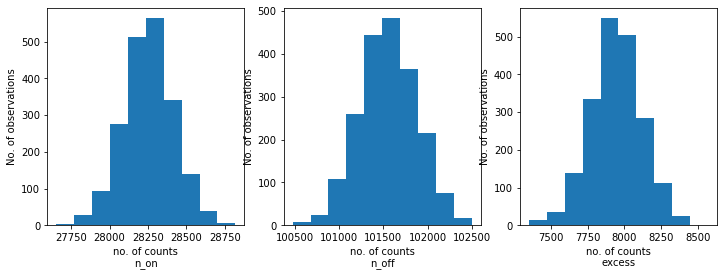

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

CPU times: user 10min 20s, sys: 3.11 s, total: 10min 23s
Wall time: 11min 15s


In [15]:
results

[{'index': 2.08918040012255,
  'amplitude': 1.850177104819134e-12,
  'lambda_': 3.673352294360042},
 {'index': 2.246807419011836,
  'amplitude': 1.1098591702415119e-12,
  'lambda_': 2.7334017535608637},
 {'index': 2.106780651085318,
  'amplitude': 1.8190278475372278e-12,
  'lambda_': 3.589715644696545},
 {'index': 2.18563790614877,
  'amplitude': 1.4182434701104837e-12,
  'lambda_': 3.2199238719446983},
 {'index': 2.2335082148813235,
  'amplitude': 1.3108606151084685e-12,
  'lambda_': 3.0577825796166618},
 {'index': 2.2509457037855745,
  'amplitude': 1.1846104974806104e-12,
  'lambda_': 2.89042551828439},
 {'index': 2.3602379548752186,
  'amplitude': 8.955689341049595e-13,
  'lambda_': 2.5390207352432648},
 {'index': 2.0765373734656976,
  'amplitude': 1.9857797497104225e-12,
  'lambda_': 3.76726993622788},
 {'index': 2.2878256000698376,
  'amplitude': 1.0410776552645376e-12,
  'lambda_': 2.7678322508808515},
 {'index': 2.283895763951333,
  'amplitude': 1.0408090689897587e-12,
  'lambda

index: 2.2145315082615267 += 0.07861386759102261


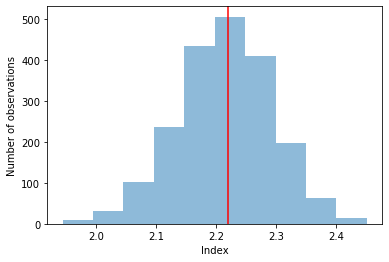

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.344427604047107e-12 += 3.175878239962322e-13


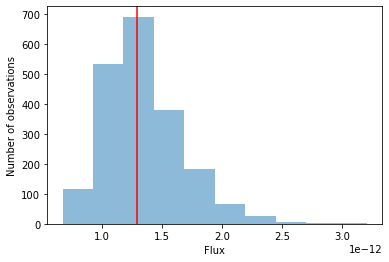

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 3.0296327389933286 += 0.4059961999951918


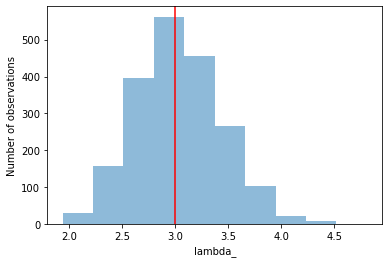

In [18]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")